# Probability Calibration
Some models can give you poor estimates of the class probabilities and some even do not support probability prediction. Well calibrated classifiers are probabilistic classifiers for which the output can be directly interpreted as a confidence level.

Calibration of the probabilities of Gaussian naive Bayes with isotonic regression can fix this issue as can be seen from the nearly diagonal calibration curve. Sigmoid calibration also improves the brier score slightly, albeit not as strongly as the non-parametric isotonic regression. This can be attributed to the fact that we have plenty of calibration data such that the greater flexibility of the non-parametric model can be exploited.

The second figure shows the calibration curve of a linear support-vector classifier (LinearSVC). LinearSVC shows the opposite behavior as Gaussian naive Bayes: the calibration curve has a sigmoid curve, which is typical for an under-confident classifier. In the case of LinearSVC, this is caused by the margin property of the hinge loss, which lets the model focus on hard sampes that are colse to the decision boudary (the support vectors).

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

Naive Bayes:
	Brier: 0.118
	Precision: 0.857
	Recall: 0.876
	F1: 0.867

Naive Bayes + Isotonic:
	Brier: 0.098
	Precision: 0.883
	Recall: 0.836
	F1: 0.859

Naive Bayes + Sigmoid:
	Brier: 0.109
	Precision: 0.861
	Recall: 0.871
	F1: 0.866

Logistic:
	Brier: 0.099
	Precision: 0.872
	Recall: 0.851
	F1: 0.862

SVC:
	Brier: 0.163
	Precision: 0.872
	Recall: 0.852
	F1: 0.862

SVC + Isotonic:
	Brier: 0.100
	Precision: 0.853
	Recall: 0.878
	F1: 0.865

SVC + Sigmoid:
	Brier: 0.099
	Precision: 0.874
	Recall: 0.849
	F1: 0.861



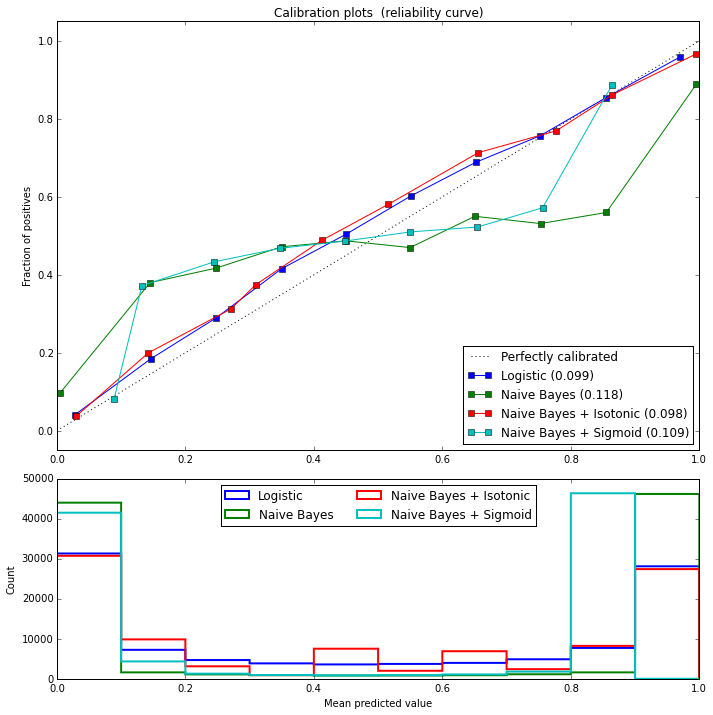

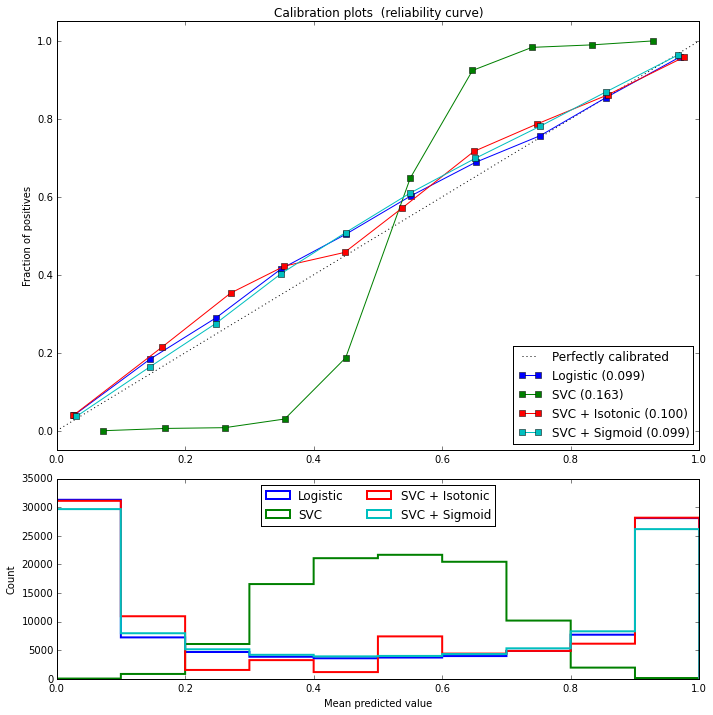

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import (brier_score_loss, precision_score, recall_score, 
                             f1_score)
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.cross_validation import train_test_split

# Create a dataset of classification task with many redundant and few informative
# features
X, y = datasets.make_classification(n_samples=100000, n_features = 20,
                                    n_informative=2, n_redundant = 10,
                                    random_state = 42)

X, y = datasets.make_classification(n_samples=100000, n_features=20,
                                    n_informative=2, n_redundant=10,
                                    random_state=42)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99,
                                                    random_state=42)


def plot_calibration_curve(est, name, fig_index):
    """Plot calibration curve for est w/o and with calibration. """
    # Calibrated with isotonic calibration
    isotonic = CalibratedClassifierCV(est, cv=2, method='isotonic')

    # Calibrated with sigmoid calibration
    sigmoid = CalibratedClassifierCV(est, cv=2, method='sigmoid')

    # Logistic regression with no calibration as baseline
    lr = LogisticRegression(C=1., solver='lbfgs')

    fig = plt.figure(fig_index, figsize=(10, 10))
    ax1 = plt.subplot2grid((3, 1), (0, 0), rowspan=2)
    ax2 = plt.subplot2grid((3, 1), (2, 0))

    ax1.plot([0, 1], [0, 1], "k:", label="Perfectly calibrated")
    for clf, name in [(lr, 'Logistic'),
                      (est, name),
                      (isotonic, name + ' + Isotonic'),
                      (sigmoid, name + ' + Sigmoid')]:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        if hasattr(clf, "predict_proba"):
            prob_pos = clf.predict_proba(X_test)[:, 1]
        else:  # use decision function
            prob_pos = clf.decision_function(X_test)
            prob_pos = \
                (prob_pos - prob_pos.min()) / (prob_pos.max() - prob_pos.min())

        clf_score = brier_score_loss(y_test, prob_pos, pos_label=y.max())
        print("%s:" % name)
        print("\tBrier: %1.3f" % (clf_score))
        print("\tPrecision: %1.3f" % precision_score(y_test, y_pred))
        print("\tRecall: %1.3f" % recall_score(y_test, y_pred))
        print("\tF1: %1.3f\n" % f1_score(y_test, y_pred))

        fraction_of_positives, mean_predicted_value = \
            calibration_curve(y_test, prob_pos, n_bins=10)

        ax1.plot(mean_predicted_value, fraction_of_positives, "s-",
                 label="%s (%1.3f)" % (name, clf_score))

        ax2.hist(prob_pos, range=(0, 1), bins=10, label=name,
                 histtype="step", lw=2)

    ax1.set_ylabel("Fraction of positives")
    ax1.set_ylim([-0.05, 1.05])
    ax1.legend(loc="lower right")
    ax1.set_title('Calibration plots  (reliability curve)')

    ax2.set_xlabel("Mean predicted value")
    ax2.set_ylabel("Count")
    ax2.legend(loc="upper center", ncol=2)

    plt.tight_layout()

# Plot calibration cuve for Gaussian Naive Bayes
plot_calibration_curve(GaussianNB(), "Naive Bayes", 1)

# Plot calibration cuve for Linear SVC
plot_calibration_curve(LinearSVC(), "SVC", 2)